In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 256
DOWNLOAD_MNIST = False
m1 = 64
m2 = 128
m3 = 512
cudaopt = True

EPS = 1e-5

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

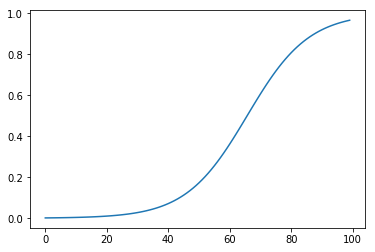

In [2]:
x = np.linspace(1,EPOCH,EPOCH)
Rhos = 1/(1+np.exp(-(x- EPOCH*6/9 )*.1))
plt.plot(Rhos)

### Model Baseline

In [3]:
Loss_test_0 = np.zeros((EPOCH,))
Acc_test_0 = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Baseline\n')
    
model = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_0[epoch] = test_loss
    Acc_test_0[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'cnn_model.pt')


					Training Baseline



N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (100.0 of 100) |#####################| Elapsed Time: 0:07:08 ETA:  0:00:00

### ML-ISTA

In [4]:
Loss_test_ista_r = np.zeros((EPOCH,))
Acc_test_ista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-ISTA \n')

T = 4

model = mds.ML_ISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    RHO = float(Rhos[epoch])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x,T,RHO)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_ista_r[epoch] = test_loss
    Acc_test_ista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
#torch.save(model.state_dict(), 'mlista_model.pt')

100% (100 of 100) |#######################| Elapsed Time: 0:07:12 Time: 0:07:12
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


					Training ML-ISTA 



C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (100.0 of 100) |#####################| Elapsed Time: 1:00:25 ETA:  0:00:00

### ML-FISTA 

In [5]:
Loss_test_fista_r = np.zeros((EPOCH,))
Acc_test_fista_r = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining ML-FISTA \n')

model = mds.ML_FISTA_NET(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    RHO = float(Rhos[epoch])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores = model(b_x,T,RHO)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma, scores = model(b_x,T,RHO)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_fista_r[epoch] = test_loss
    Acc_test_fista_r[epoch] =  100 * float(correct) /float(len(test_loader.dataset))

100% (100 of 100) |#######################| Elapsed Time: 1:01:02 Time: 1:01:02
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


					Training ML-FISTA 



C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
100% (100.0 of 100) |#####################| Elapsed Time: 1:00:29 ETA:  0:00:00

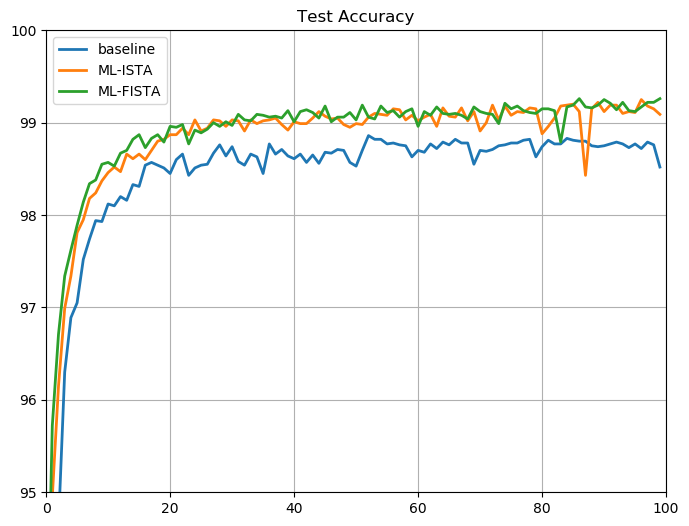

In [23]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_test_0, linewidth = 2,label='baseline')
plt.plot(Acc_test_ista_r, linewidth = 2,label = 'ML-ISTA')
plt.plot(Acc_test_fista_r, linewidth = 2,label = 'ML-FISTA')

plt.grid('on')
plt.title('Test Accuracy')
plt.legend()
plt.axis([0, 100, 95, 100])
plt.show()